# Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
В качестве метрики используем RMSE. Удовлетворительным уровнем будет считаться, если метрика на тестовой выборке не будет превышать 48.

Порядок выполнения проекта:
1. Загрузим и подготовим данные, выполнив ресемплирование по одному часу.
2. Проанализируем данные
3. Обучим 2 модели: линейную регрессию и градиентный бустинг. Размер тестовой выборки составит 10% от всех данных.
4. Проверим качество моделей на тестовой выборке.
5. Сделаем выводы по проделанной работе.

In [8]:
#import
import pandas as pd
import numpy as np
import phik
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

# Визуализация данных:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    # Разбиение данных
    train_test_split,

    # Поиск гиперпараметров
    RandomizedSearchCV,
    
    # Кросс-валидация временных рядов
    TimeSeriesSplit
)

from sklearn.preprocessing import (
    # Кодирование числовых значений
    StandardScaler,
    MinMaxScaler,
    RobustScaler,

    # Кодирование категориальных значение
    OneHotEncoder,
)

# Импорт для создания пайплайна
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
)
from catboost import CatBoostRegressor
from prophet import Prophet

# Импорт для подбора гиперпараметров
from optuna.integration import OptunaSearchCV
from optuna.distributions import (
    IntDistribution,
    FloatDistribution,
    CategoricalDistribution
)

# Импорт метрики
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings('ignore')

In [9]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Загрузка данных:

Загрузим данные, после чего проверим корректность типов данных и наличие пропусков. Ресемплируем данные по одному часу, чтобы получить количество заказов такси в каждом часе.

In [10]:
# Загружаем данные
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
except FileNotFoundError:
    df = pd.read_csv('data/taxi.csv', parse_dates=['datetime'])

In [11]:
# Проверяем порядок и период дат
print(f'Первая строка датасета:             {df.loc[df.index[0], "datetime"]}')
print(f'Самая ранняя запись в датасете:     {df["datetime"].min()}\n\n')

print(f'Последняя строка датасета:          {df.loc[df.index[-1], "datetime"]}')
print(f'Самая поздняя запись в датасете:    {df["datetime"].max()}\n\n')

# Выводим датасет
df

Первая строка датасета:             2018-03-01 00:00:00
Самая ранняя запись в датасете:     2018-03-01 00:00:00


Последняя строка датасета:          2018-08-31 23:50:00
Самая поздняя запись в датасете:    2018-08-31 23:50:00




,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [12]:
 # Выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [13]:
# Проверям данные на монотонность
df['datetime'].is_monotonic_increasing

True

In [14]:
# Ресемплируем данные
df = df.resample('1H', on='datetime').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [15]:
# Проверяем корректность
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы:

- Период дат в датасете с 2018-03-01 по 2018-08-31.
- Данные загружены корректно, типы данных соответствуют ожидаемым.
- Пропусков в данных нет.
- Данные ресемплированы по одному часу, общее количество записей сократилось с 26 500 до 4 500
- Столбец `datetime` стал индексом, что позволит удобно работать с временными рядами.
- Столбец с датой так же является монотонным

## Исследовательский анализ данных:

Посмотрим на график количества заказов такси по часам, чтобы выявить тренды и сезонность. Также проверим наличие выбросов в данных.

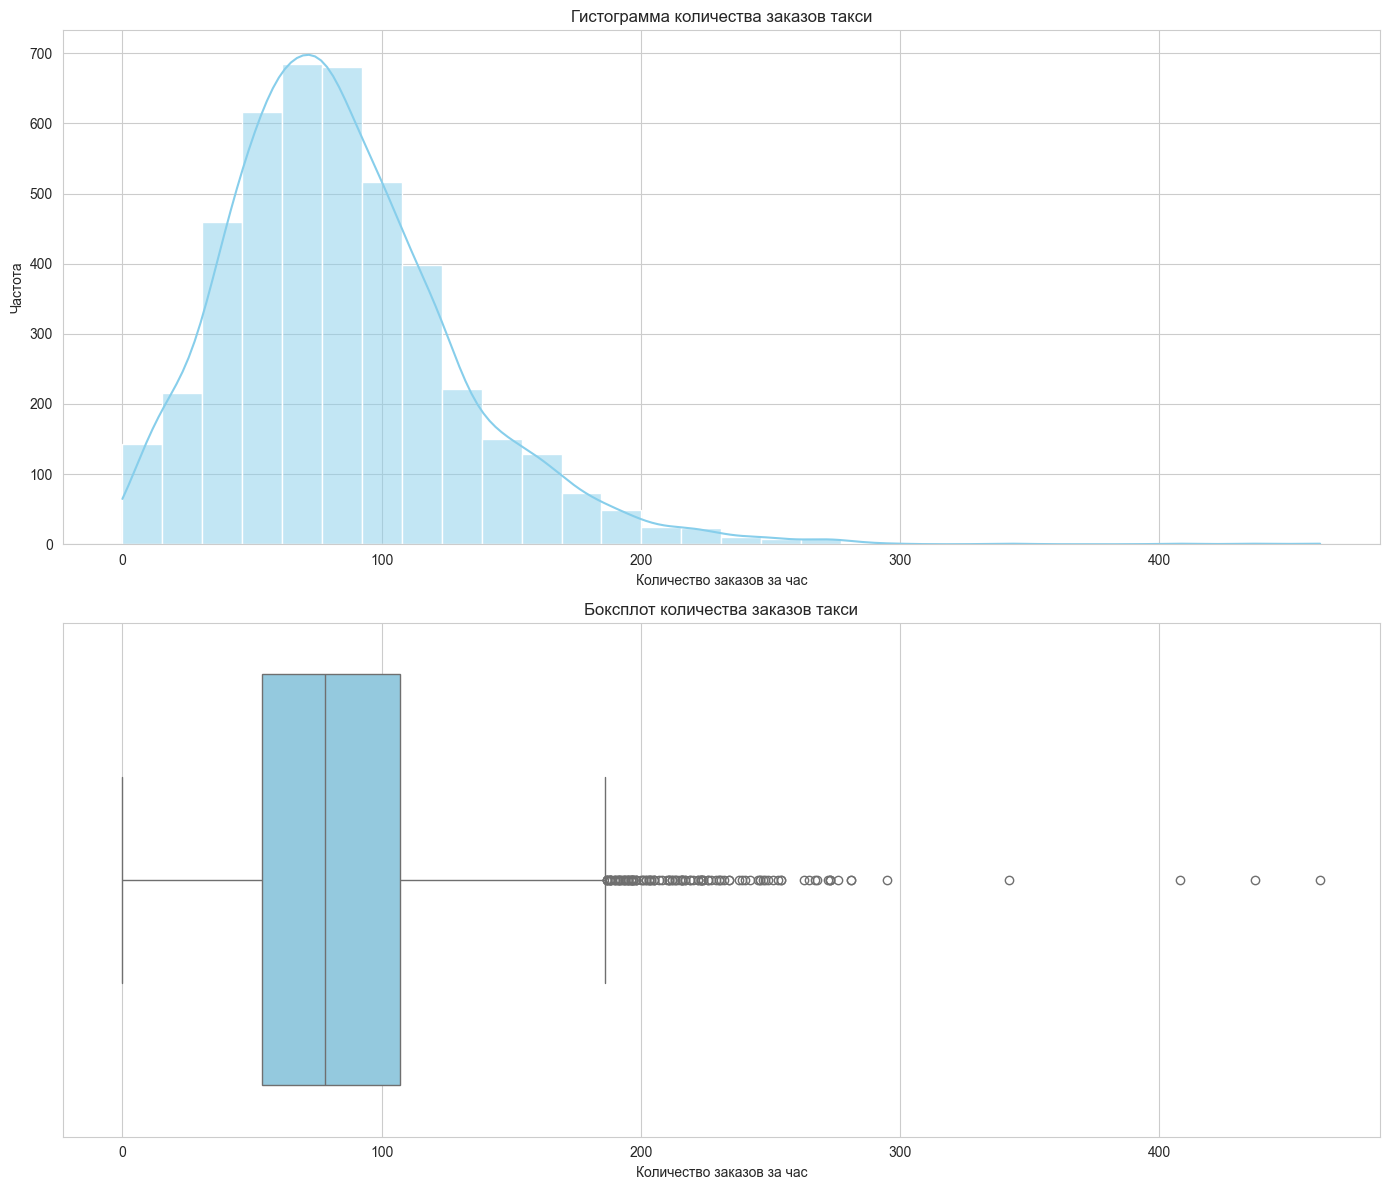

In [16]:
# Создаем фигуру с двумя подграфиками
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Создаем гистограмму для количества заказов
sns.histplot(data=df, x='num_orders', bins=30, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Гистограмма количества заказов такси')
ax[0].set_xlabel('Количество заказов за час')
ax[0].set_ylabel('Частота')

# Рисуем боксплот для количества заказов
sns.boxplot(data=df, x='num_orders', color='skyblue', ax=ax[1])
ax[1].set_title('Боксплот количества заказов такси')
ax[1].set_xlabel('Количество заказов за час')

# Отображаем графики
plt.tight_layout()
plt.show()

У нас есть выбросы, однако они находятся в пределах разумного. Количество заказов такси в час варьируется от 0 до 200 (в среднем 50-90 заказов).

Выделим из даты месяц, день, и день недели, после чего создадим сводные таблицы, чтобы провести более детальный анализ.

In [17]:
# Добавляем столбцы с месяцем, днем и днем недели
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

# Выводим датасет
df

,num_orders,month,day,day_of_week,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4
...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19
2018-08-31 20:00:00,154,8,31,4,20
2018-08-31 21:00:00,159,8,31,4,21


In [18]:
def draw_pivot_table(pivot_table,
                     title='Заголовок', xlabel='Ось Х',
                     label_dict={i: str(i) for i in range(32)}) -> None:
    """
    Функция для построения графика медианниого количества заказов из сводной таблицы.

    :param pivot_table: Сводная таблица
    :param title: Заголовок графика
    :param xlabel: Подпись оси X
    :param label_dict: Словарь с названиями месяцев или дней недели. По умолчанию - номера от 0 до 31.
    """
    plt.figure(figsize=(14, 6))

    # График для медианы
    ax = sns.barplot(x=pivot_table.index, y=pivot_table[('median', 'num_orders')], palette='coolwarm')
    plt.title(title, fontsize=14)
    plt.ylabel('Количество заказов (медиана)')
    plt.xlabel(xlabel)
    plt.xticks(range(len(pivot_table.index)))
    plt.gca().set_xticklabels([label_dict[i] for i in pivot_table.index])

    # Добавляем линию тренда
    sns.lineplot(x=range(len(pivot_table.index)), y=pivot_table[('median', 'num_orders')], color='red', marker='o')

    plt.tight_layout()
    plt.show()

In [19]:
# Создаем сводную таблицу по месяцам
pivot_month = df.pivot_table(index='month', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_month

,median,sum,count
,num_orders,num_orders,num_orders
month,,,
3,55.0,42768,744
4,61.0,45939,720
5,71.0,54820,744
6,83.0,59906,720
7,98.0,74405,744
8,122.0,94973,744


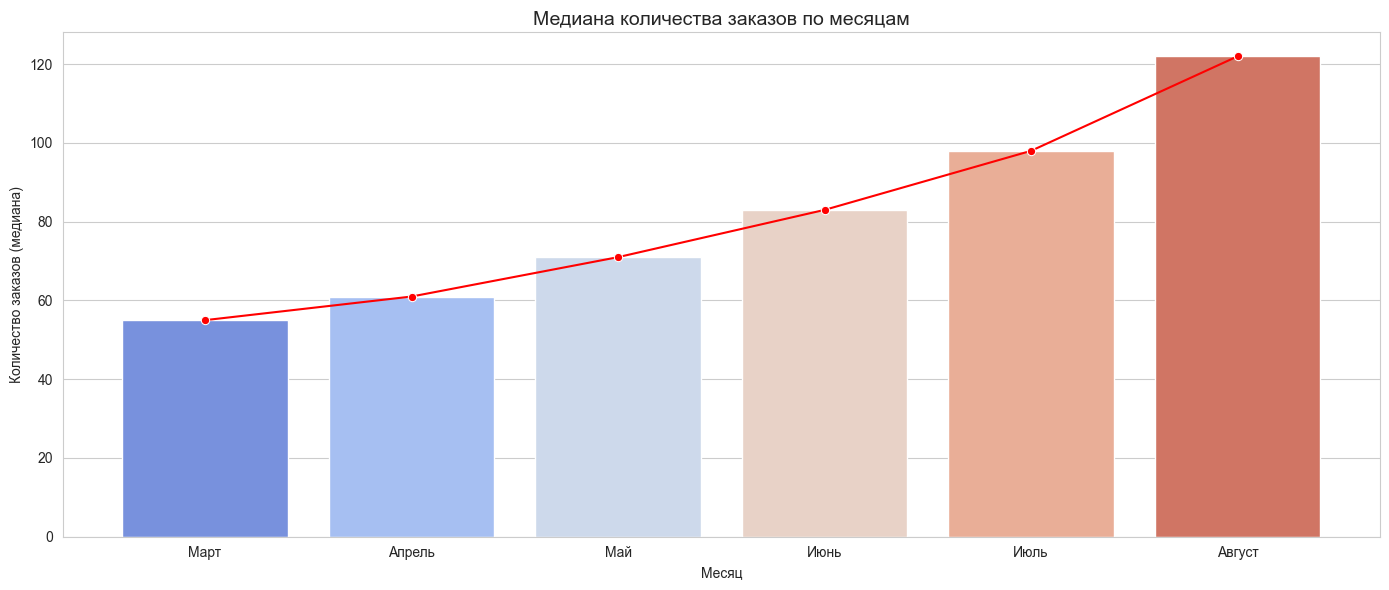

In [20]:
# Рисуем график медианного количества заказов по месяцам
draw_pivot_table(pivot_month, 'Медиана количества заказов по месяцам', 'Месяц',
                 label_dict={3: 'Март',
                             4: 'Апрель',
                             5: 'Май',
                             6: 'Июнь',
                             7: 'Июль',
                             8: 'Август'})


In [21]:
# Создаем сводную таблицу по дням
pivot_day = df.pivot_table(index='day', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_day

,median,sum,count
,num_orders,num_orders,num_orders
day,,,
1,70.5,10418,144
2,71.5,11053,144
3,65.0,10525,144
4,72.0,10437,144
5,65.0,9931,144
6,73.5,11245,144
7,73.5,10919,144
8,77.5,11182,144


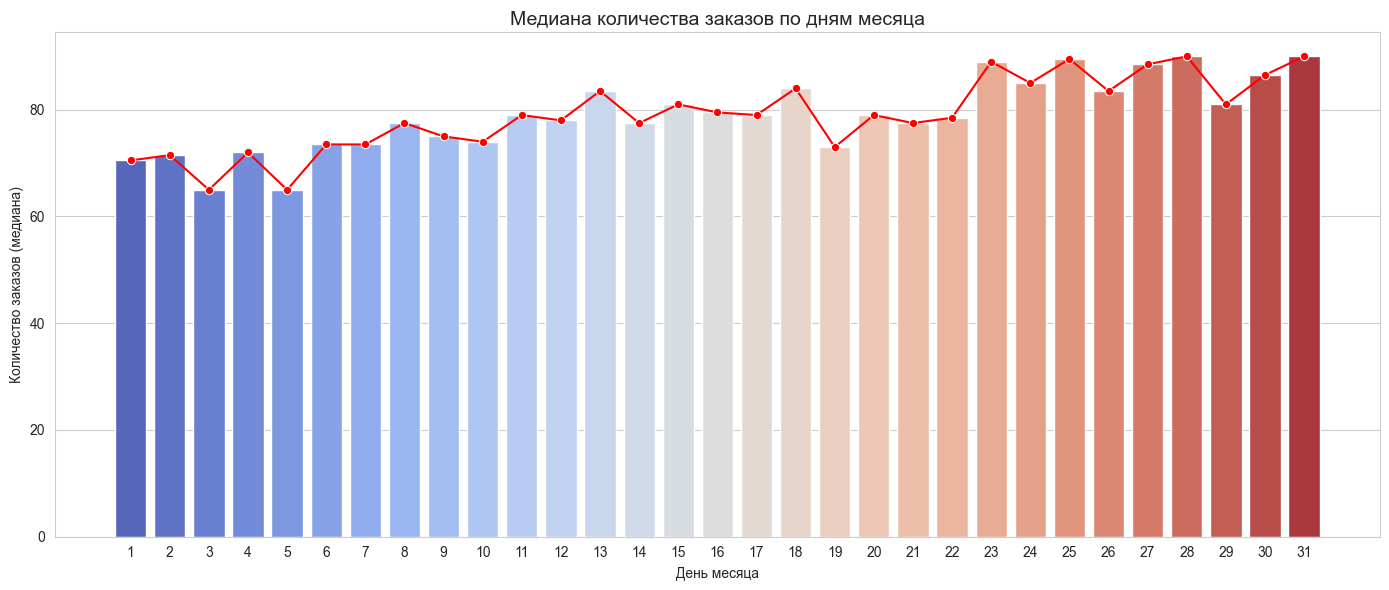

In [22]:
# Рисуем график медианного количества заказов по дням
draw_pivot_table(pivot_day, 'Медиана количества заказов по дням месяца', 'День месяца')

In [23]:
# Создаем сводную таблицу по дням недели
pivot_day_of_week = df.pivot_table(index='day_of_week', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_day_of_week

,median,sum,count
,num_orders,num_orders,num_orders
day_of_week,,,
0,81.5,56314,624
1,72.5,48055,624
2,80.0,52263,624
3,78.0,55508,648
4,87.0,59059,648
5,76.0,52321,624
6,75.5,49291,624


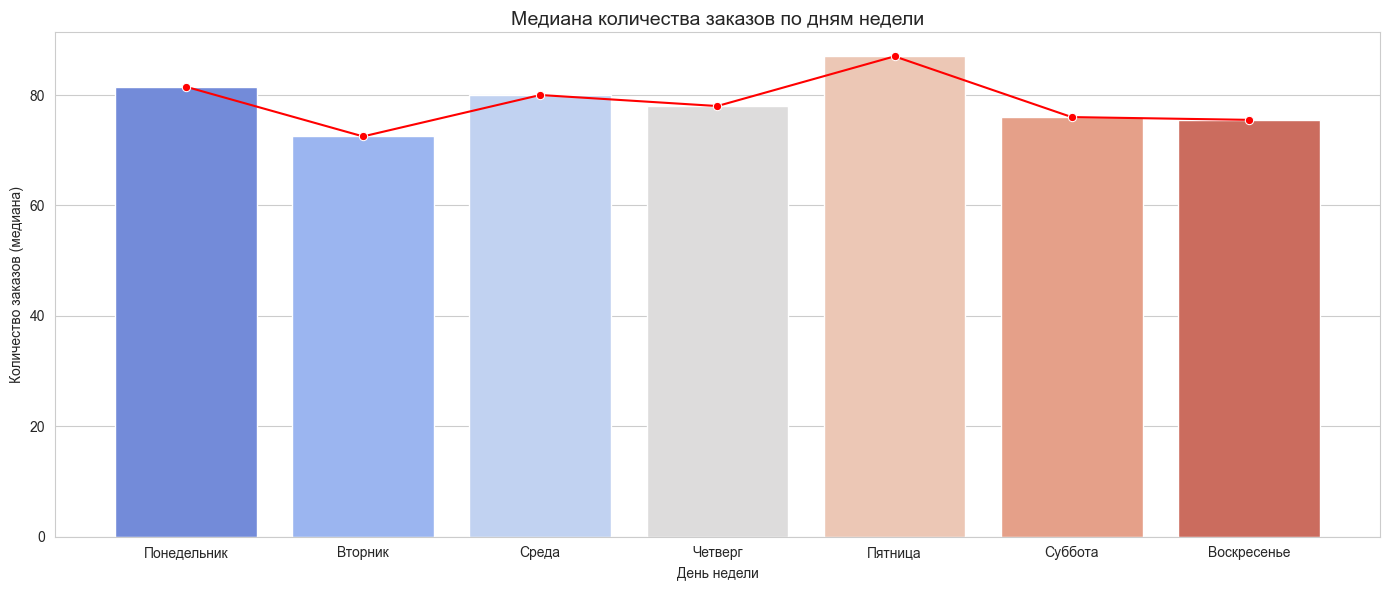

In [24]:
# Рисуем график медианного количества заказов по дням недели
draw_pivot_table(pivot_day_of_week, 'Медиана количества заказов по дням недели', 'День недели',
                 label_dict={0: 'Понедельник',
                             1: 'Вторник',
                             2: 'Среда',
                             3: 'Четверг',
                             4: 'Пятница',
                             5: 'Суббота',
                             6: 'Воскресенье'})

In [25]:
# Создаем сводную таблицу по дням недели
pivot_hour = df.pivot_table(index='hour', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_hour

,median,sum,count
,num_orders,num_orders,num_orders
hour,,,
0,142.0,26570,184
1,93.5,19203,184
2,104.5,20805,184
3,96.5,18772,184
4,83.0,15991,184
5,37.5,7844,184
6,19.0,4632,184
7,27.0,5386,184


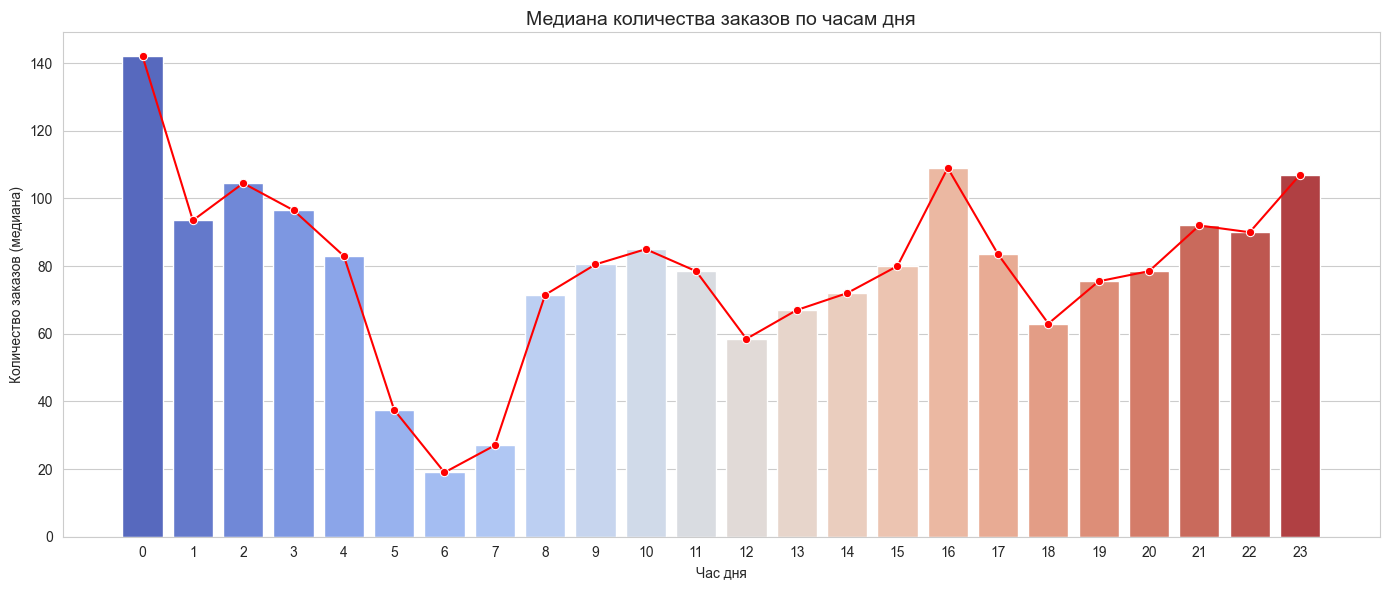

In [26]:
# Рисуем график медианного количества заказов по часам
draw_pivot_table(pivot_hour, 'Медиана количества заказов по часам дня', 'Час дня')

In [27]:
# Выполняем декомпозицию временного ряда
decomposed = seasonal_decompose(df['num_orders'], period=24, extrapolate_trend='freq', two_sided=False)

In [28]:
# Выводим тренд временных рядов
decomposed.trend

datetime
2018-03-01 00:00:00     49.776893
2018-03-01 01:00:00     49.982708
2018-03-01 02:00:00     50.188524
2018-03-01 03:00:00     50.394339
2018-03-01 04:00:00     50.600154
                          ...    
2018-08-31 19:00:00    166.208333
2018-08-31 20:00:00    167.791667
2018-08-31 21:00:00    167.229167
2018-08-31 22:00:00    167.770833
2018-08-31 23:00:00    168.270833
Freq: h, Name: trend, Length: 4416, dtype: float64

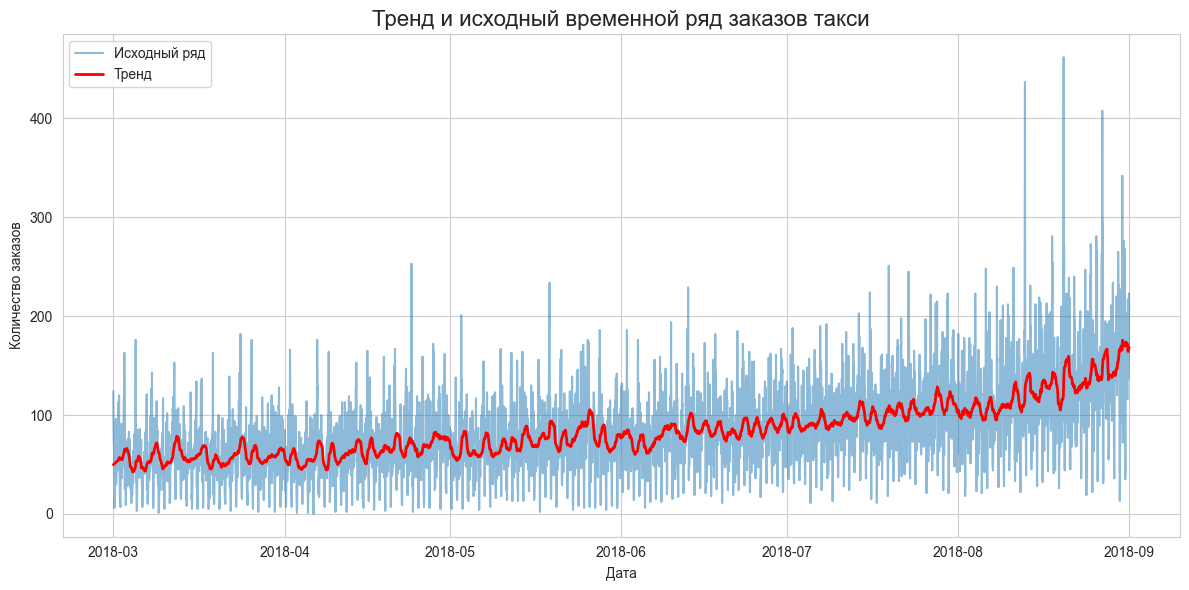

In [29]:
plt.figure(figsize=(12, 6))

# Отрисовываем исходный ряд
plt.plot(df['num_orders'], label='Исходный ряд', alpha=0.5)

# Отрисовываем тренд
plt.plot(decomposed.trend, label='Тренд', color='red', linewidth=2)

# Настраиваем график
plt.title('Тренд и исходный временной ряд заказов такси', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.tight_layout()
plt.show()

Мы видим, что значения тренда увеличиваются от марта (около 50 заказов) к августу (около 168 заказов). Это указывает на общий восходящий тренд в спросе 

In [30]:
# Вывозим сезонность
decomposed.seasonal.tail(24)

datetime
2018-08-31 00:00:00    60.273893
2018-08-31 01:00:00    20.205180
2018-08-31 02:00:00    28.880239
2018-08-31 03:00:00    17.808468
2018-08-31 04:00:00     2.664007
2018-08-31 05:00:00   -41.647913
2018-08-31 06:00:00   -59.116310
2018-08-31 07:00:00   -55.025716
2018-08-31 08:00:00   -11.269928
2018-08-31 09:00:00     4.479633
2018-08-31 10:00:00     8.737006
2018-08-31 11:00:00    -1.916966
2018-08-31 12:00:00   -16.796821
2018-08-31 13:00:00   -13.281635
2018-08-31 14:00:00    -9.318420
2018-08-31 15:00:00     3.447785
2018-08-31 16:00:00    29.624656
2018-08-31 17:00:00     8.162600
2018-08-31 18:00:00   -15.237409
2018-08-31 19:00:00    -7.285742
2018-08-31 20:00:00    -2.785955
2018-08-31 21:00:00    10.545127
2018-08-31 22:00:00    13.809068
2018-08-31 23:00:00    25.045155
Freq: h, Name: seasonal, dtype: float64

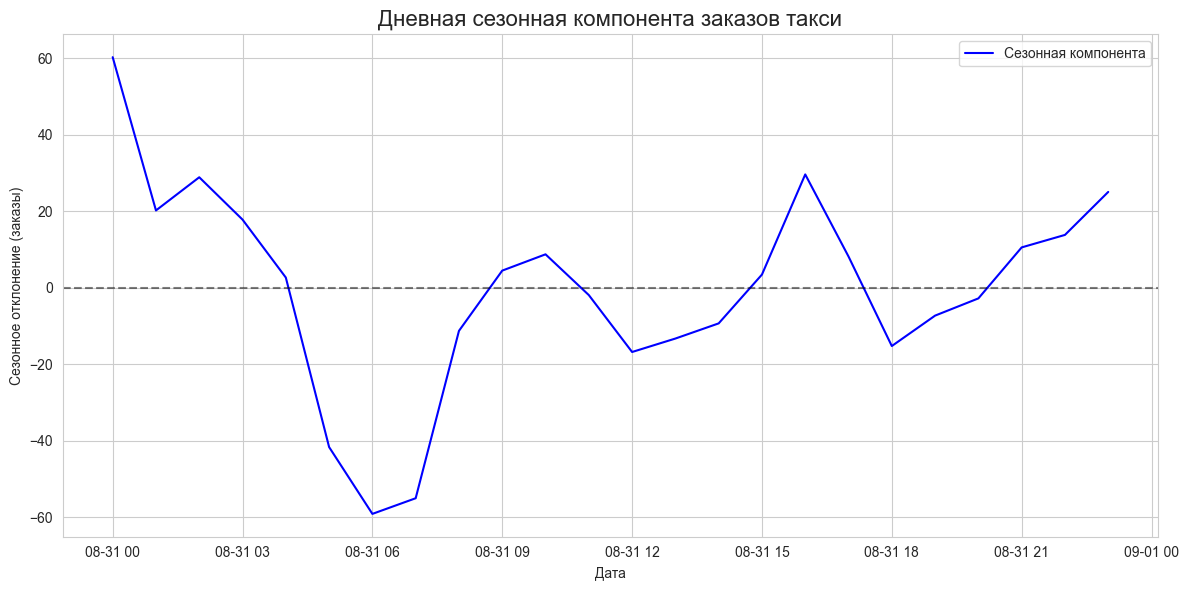

In [31]:
# Смотрим на дневную сезонность
plt.figure(figsize=(12, 6))

# Выбираем данные за последний день
day = decomposed.seasonal[-24:]

# Отрисовываем сезонную компоненту
plt.plot(day, label='Сезонная компонента', color='blue')

# Настраиваем график
plt.title('Дневная сезонная компонента заказов такси', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Сезонное отклонение (заказы)')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)  # Линия нуля
plt.legend()
plt.tight_layout()
plt.show()

Мы видим, что сезонность сильно падает с ночи к утру, после чего сезонность не сильно варируется в течении дня. Можно выделить небольшое увелечение заказов такси ближе к вечеру (17:00)

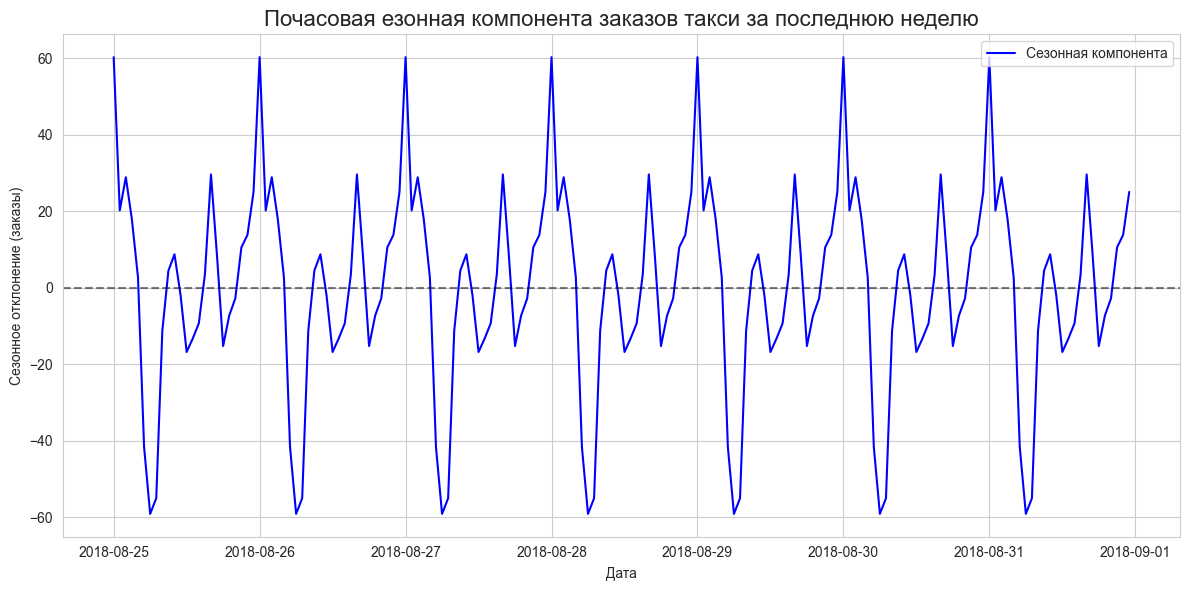

In [32]:
# Смотрим на недельную сезонность
plt.figure(figsize=(12, 6))

# Выбираем данные за последнюю неделю
last_week = decomposed.seasonal[-168:]

# Отрисовываем сезонную компоненту
plt.plot(last_week, label='Сезонная компонента', color='blue')

# Настраиваем график
plt.title('Почасовая езонная компонента заказов такси за последнюю неделю', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Сезонное отклонение (заказы)')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)  # Линия нуля
plt.legend()
plt.tight_layout()
plt.show()

Значения сезонной компоненты показывают, насколько количество заказов такси отклоняется от тренда в определенные часы дня из-за суточной сезонности

Отрицательные значения указывают, что в эти часы спрос на такси ниже среднего уровня (тренда) для данного времени года. Например, в 19:00 спрос на 7.29 заказов ниже, чем ожидалось бы на основе тренда.

Положительные значения аналогичным образом указывают, что в эти часы спрос выше среднего уровня. Например, в 23:00 спрос на 25.05 заказов выше, чем ожидалось бы на основе тренда.

In [33]:
df_weekly = df['num_orders'].copy()

# # Ресемплируем данные по неделе
df_weekly = pd.DataFrame(df_weekly.resample('1D').sum())
df_weekly

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
...,...
2018-08-27,3936
2018-08-28,3357
2018-08-29,3762


In [34]:
# Выполняем декомпозицию временного ряда
decomposed_weekly = seasonal_decompose(df_weekly['num_orders'], period=7)

In [35]:
# Выводим сезонность
decomposed_weekly.seasonal

datetime
2018-03-01     13.568634
2018-03-02    137.511491
2018-03-03     24.505777
2018-03-04   -106.092025
2018-03-05    149.045338
                 ...    
2018-08-27    149.045338
2018-08-28   -182.410706
2018-08-29    -36.128509
2018-08-30     13.568634
2018-08-31    137.511491
Freq: D, Name: seasonal, Length: 184, dtype: float64

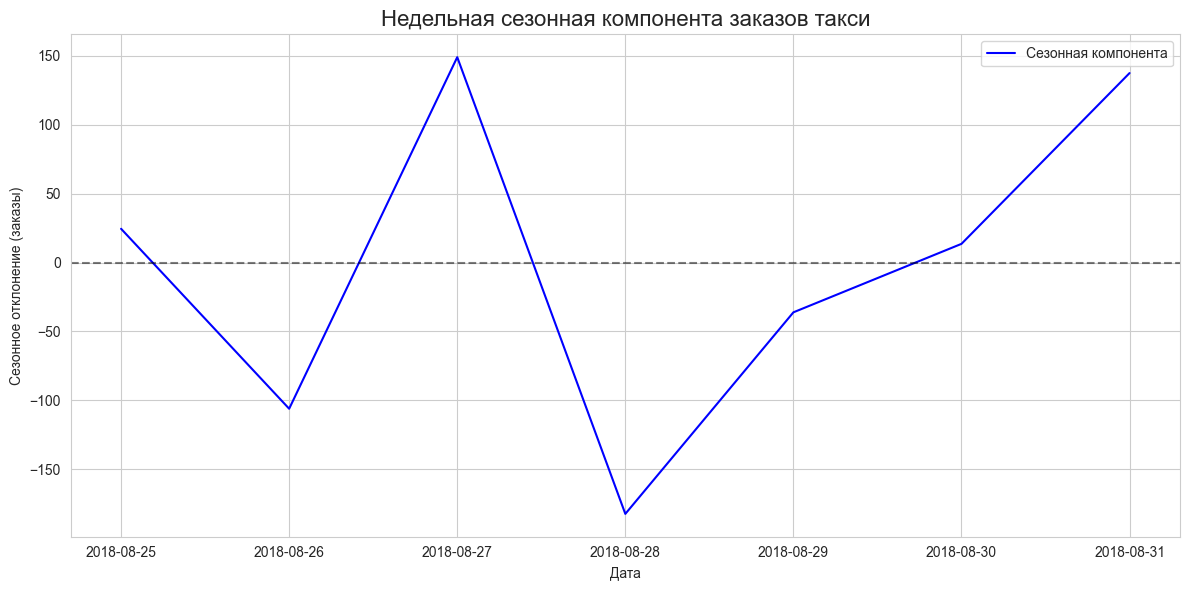

In [36]:
# Смотрим на недельную сезонность
plt.figure(figsize=(12, 6))

# Отрисовываем сезонную компоненту
plt.plot(decomposed_weekly.seasonal[-7:], label='Сезонная компонента', color='blue')

# Настраиваем график
plt.title('Недельная сезонная компонента заказов такси', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Сезонное отклонение (заказы)')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)  # Линия нуля
plt.legend()
plt.tight_layout()
plt.show()

31-е августа 2018 было пятнице, значит график показывает, что количество заказов растет с воскресенья к понедельнику и со вторника к пятнице

In [37]:
# Выводим остатки
decomposed.resid

datetime
2018-03-01 00:00:00    13.949213
2018-03-01 01:00:00    14.812112
2018-03-01 02:00:00    -8.068762
2018-03-01 03:00:00    -2.202807
2018-03-01 04:00:00   -10.264161
                         ...    
2018-08-31 19:00:00   -22.922591
2018-08-31 20:00:00   -11.005712
2018-08-31 21:00:00   -18.774294
2018-08-31 22:00:00    41.420099
2018-08-31 23:00:00    11.684012
Freq: h, Name: resid, Length: 4416, dtype: float64

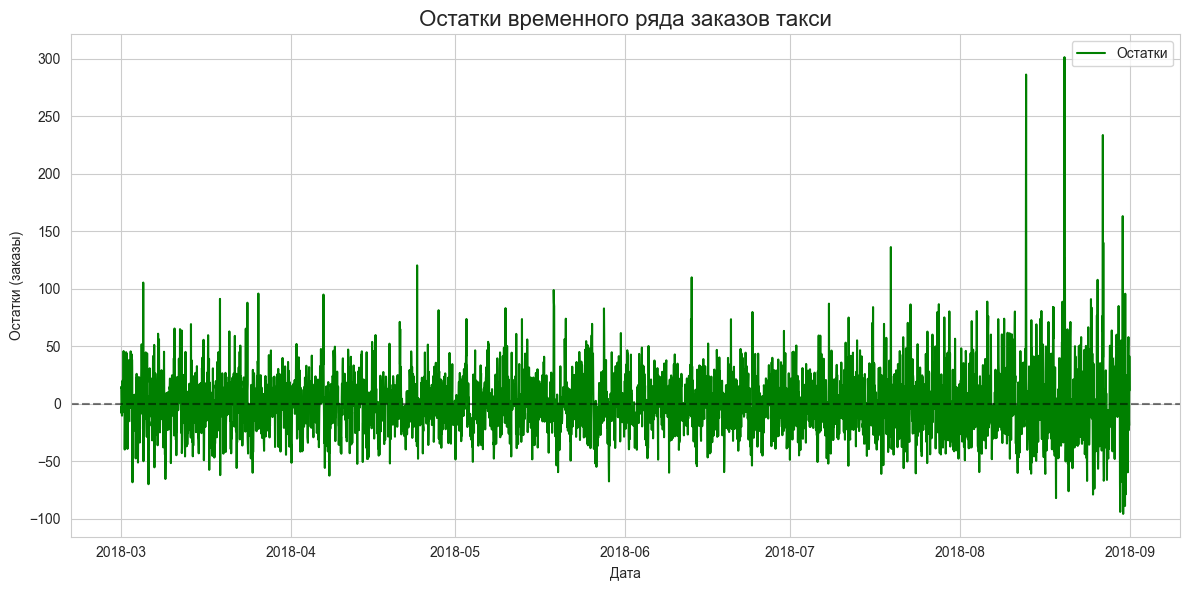

In [38]:
plt.figure(figsize=(12, 6))

# Отрисовываем остатки
plt.plot(decomposed.resid, label='Остатки', color='green')

# Настраиваем график
plt.title('Остатки временного ряда заказов такси', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Остатки (заказы)')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)  # Линия нуля
plt.legend()
plt.tight_layout()
plt.show()

Остатки, показывающие случайные или необъясняемы колебания, распределены равномерно, чуть-чуть увеличиваясь ближе к концу датасета. Есть единичные выбросы ближе к концу августа

In [39]:
# Удаляем ненужные датафреймы
del (
    pivot_month,
    pivot_day,
    pivot_day_of_week,
    pivot_hour,
    df_weekly,
    decomposed, decomposed_weekly,
    day, last_week,
)

### Выводы:

В данных присутсвуют выбросы, однако это не ошибка системы, а просто высокая нагруженность. Например, одновременный прилет большого количества рейсов в аэропорт, что приводит к большому количеству заказов такси. Количество заказов такси в час варьируется от 0 до 200 (в среднем 50-90 заказов).

Мы создали сводные таблицы по месяцам, дням, дням недели, и часам дня. Количество заказов не особо зависит от дня месяца или дня недели. Однако с приближением лета количество заказов такси сильно увеличивается, что потенциально связано с тем, что летом чаще берут отпуска. Такси чаще заказывают в ночные часы (23-04), что подтверждает график дневной сезонности. Меньше всего такси заказываю в утренние часы (05-08).
В каждом месяце/дне/дне недели/часу количество записей примерно одинаковое, тут никакого дисбаланса нет.

Тренд идет на возрастание, без особого ускорения

## Корреляционный анализ:

Выведем матрицу корреляции, чтобы понять, какой из признаков больше всего влияет на таргет. Так же проверим данные на наличие мультиколлинеарности, чтобы избежать проблем при обучении модели.

In [40]:
num_cols = ['num_orders']

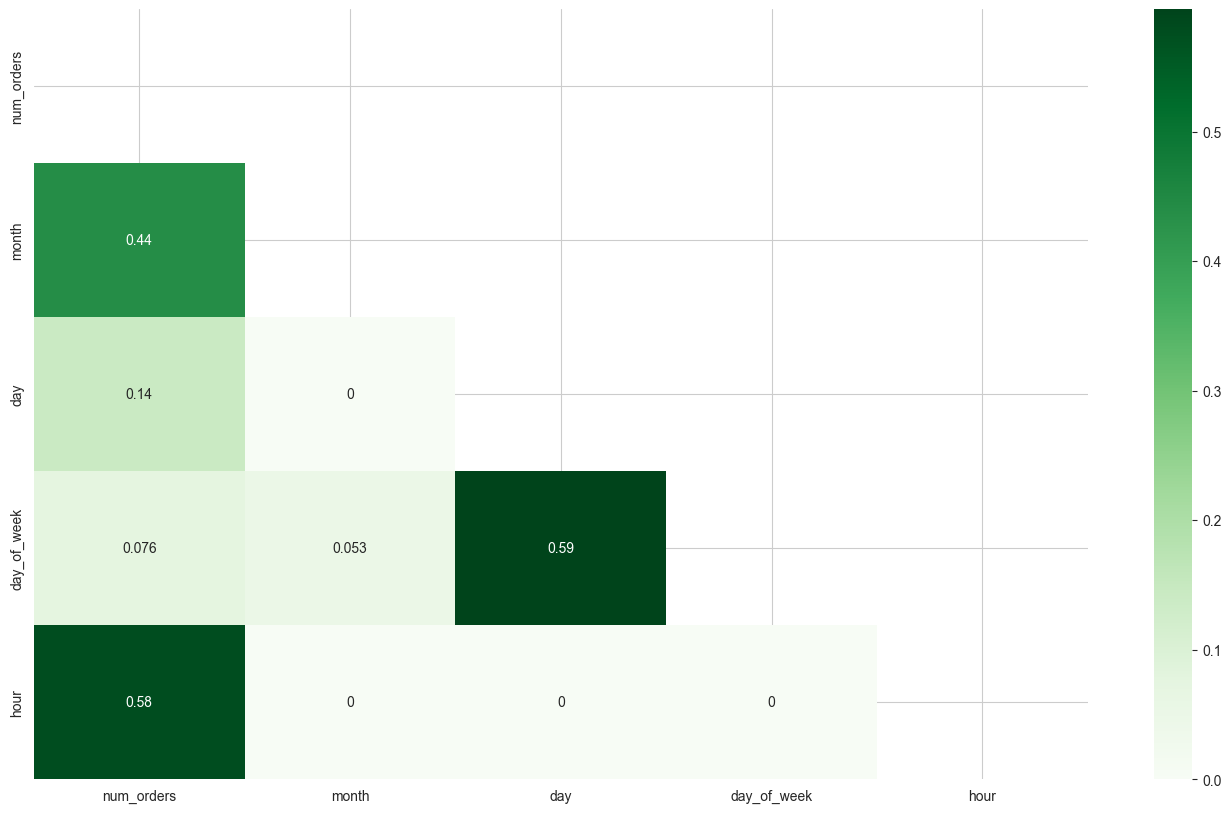

In [41]:
plt.figure(figsize=(17, 10))

# Рисуем матрицу корреляции
sns.heatmap(df.phik_matrix(interval_cols=num_cols),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(
                df.phik_matrix(interval_cols=num_cols),
                dtype=bool)))

plt.show()

В признаках нет мультиколлинеарности, а больше всего таргет коррелирует с часом дня. Околонулевая корреляция наблюдается с признаком "день недели". Удалим этот признак и создадим новые:
- `is_weekend` - признак, является ли день выходным (суббота или воскресенье)
- `lag_n` - Признак, который подскажет, будет ли функция уменьшаться или увеличиваться
- `rolling_mean` - Скользящее среднее за n часов.

### Создание новых признаков:

Создадим новые признаки, которые мы описали выше. Для создания признаков `lag_n` и `rolling_mean` напишем функцию, чтобы можно было менять параметры `n` и `window_size`.

In [42]:
# Выделяем выходные
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

# Удаляем признак с околонулевой корреляцией
df = df.drop('day_of_week', axis=1)

# Выводим датасет
df

,num_orders,month,day,hour,is_weekend
datetime,,,,,
2018-03-01 00:00:00,124,3,1,0,0
2018-03-01 01:00:00,85,3,1,1,0
2018-03-01 02:00:00,71,3,1,2,0
2018-03-01 03:00:00,66,3,1,3,0
2018-03-01 04:00:00,43,3,1,4,0
...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,0
2018-08-31 20:00:00,154,8,31,20,0
2018-08-31 21:00:00,159,8,31,21,0


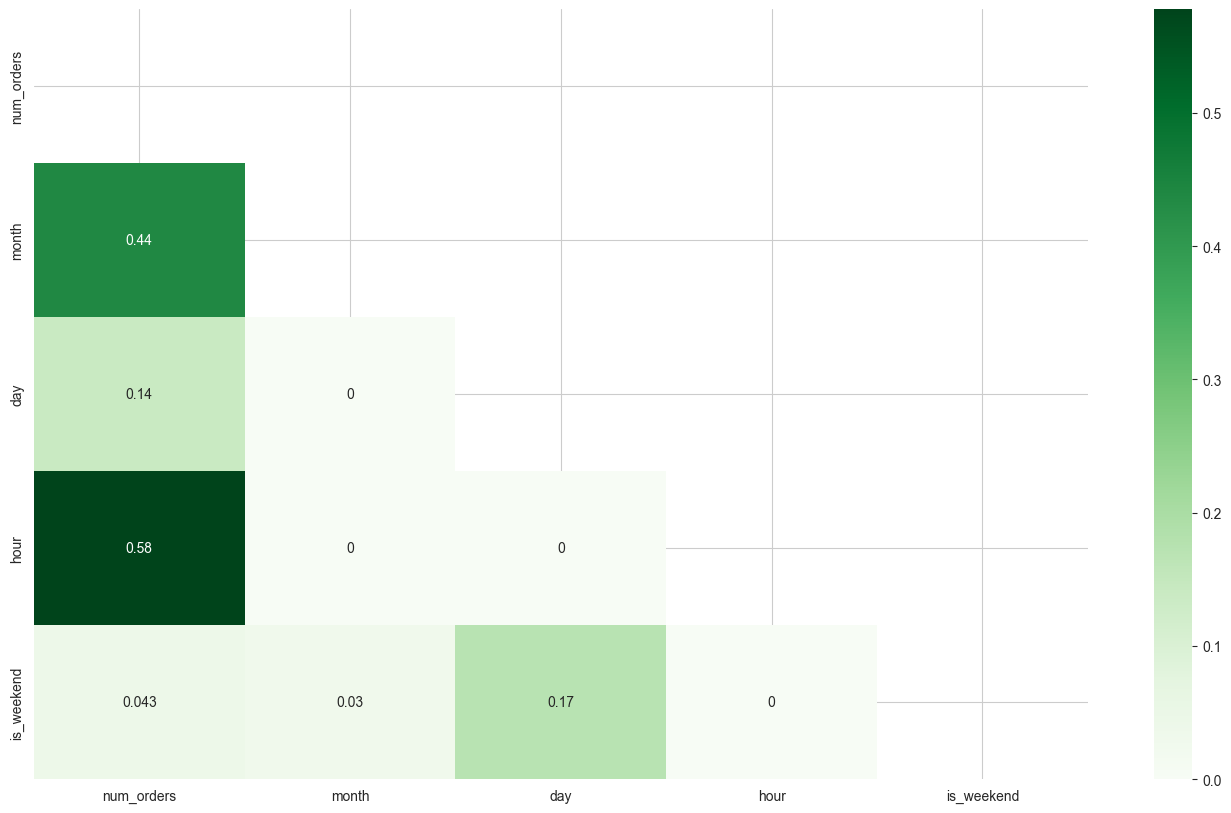

In [43]:
plt.figure(figsize=(17, 10))

# Рисуем матрицу корреляции перед добавлением lag_n и rolling_mean, потому что они будут зависеть от параметров n и window_size
sns.heatmap(df.phik_matrix(interval_cols=num_cols),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(
                df.phik_matrix(interval_cols=num_cols),
                dtype=bool)))

plt.show()

У нас слишком мало данных о месяцах, чтобы включать их в модель. Если бы у нас были данные за 2-3 года, то можно было бы включить этот признак, потому что это позовлило бы увидеть закономерности в разрезе лет

In [44]:
# Удаляем признак `is_weekend`, так как у него низкая корреляция
df = df.drop('is_weekend', axis=1)

# Удаляем признак `month`, так как у нас недостаточно данных
df = df.drop('month', axis=1)

In [45]:
def create_lag_and_rolling(df: pd.DataFrame, n: int = 24, window_size: int = 6) -> pd.DataFrame:
    """
    Функция для создания признаков lag_n и rolling_mean.

    :param df: Датафрейм с данными
    :param n: Количество отстающих значений для lag_n
    :param window_size: Размер окна для скользящего среднего
    :return: Датафрейм с новыми признаками
    """
    # Создаем признак rolling_mean
    df[f'rolling_mean_{window_size}'] = df['num_orders'].shift(1).rolling(window=window_size).mean()

    # Создаем признак lag_n
    for i in range(1, n + 1):
        df[f'lag_{i}'] = df['num_orders'].shift(i)

    return df

In [46]:
# Применяем функцию
df = create_lag_and_rolling(df, n=168, window_size=6)

# Выводим датасет
df

,num_orders,day,hour,rolling_mean_6,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,NaN,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,NaN,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,NaN,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,4,NaN,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,19,172.666667,207.0,217.0,197.0,116.0,133.0,166.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0
2018-08-31 20:00:00,154,31,20,167.666667,136.0,207.0,217.0,197.0,116.0,133.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0
2018-08-31 21:00:00,159,31,21,171.166667,154.0,136.0,207.0,217.0,197.0,116.0,...,74.0,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0


In [47]:
# Удаляем строки с пропусками, так как информацию о мы сохранили в новых признаках
df = df.dropna()

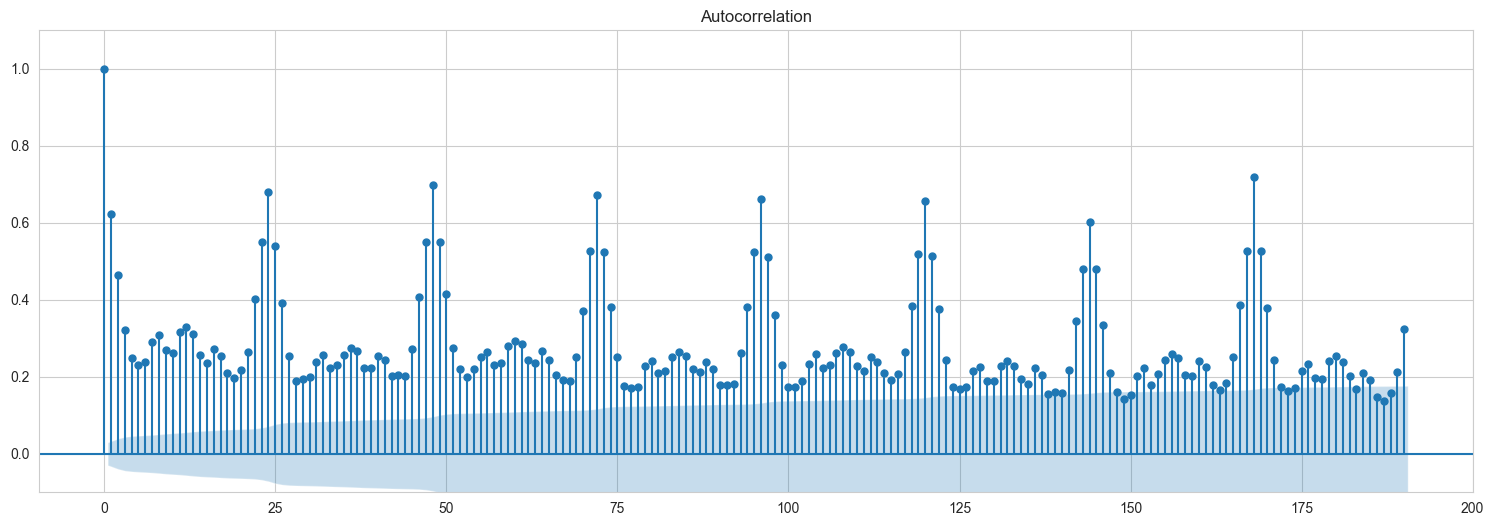

In [48]:
# Проверяем корреляцию после добавления лагов
taxi = pd.read_csv("data/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

### Вывод:

Из всех созданных признаков смысл имеет только следующие:

- `hour` - Час заказа
- `lag_n` - Признак, который подскажет, будет ли функция уменьшаться или увеличиваться
- `rolling_mean` - Скользящее среднее за n часов.

## Создание моделей:

Создадим 3 модели: Baseline, CatBoost, Prophet. Размер тестовой выборки составит 10% от всех данных. В качестве метрики будем использовать RMSE.

### Подготовка данных:

In [49]:
# Определяем категориальные и числовые признаки
ord_cols = ['day', 'hour']
num_cols = list(set(df.columns) - set(ord_cols) - {'num_orders'})

# Проверяем, ну упустили ли мы что-то
print(set(df.columns) - set(ord_cols + num_cols))
print(set(ord_cols + num_cols) - set(df.columns))

{'num_orders'}
set()


In [50]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('num_orders', axis=1),
    df['num_orders'],
    test_size=0.1,
    shuffle=False
)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Верно, ничего не перемешиваем.
</div>


In [51]:
# Выводим размерности всех выборок
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3823, 171)
y_train: (3823,)

X_test: (425, 171)
y_test: (425,)


In [52]:
# Проверяем, последовательно ли у нас идут данные
print(X_train.index[-1])
print(X_test.index[0])

2018-08-14 06:00:00
2018-08-14 07:00:00


In [53]:
# Создаем кросс-валидацию для временных рядов
tscv = TimeSeriesSplit(n_splits=5)

### Создание пайплайна:

Создадим пайплайн для обработки данных

In [54]:
# Пайплайн для числовых значений
num_pipeline = Pipeline(
    [
        (
            'imputer_before_scaler',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'num',
            StandardScaler()
        ),
    ]
)

In [55]:
# Создаем препроцессор данных
data_preprocessor = ColumnTransformer(
    [
        ('num_preprocessor', num_pipeline, num_cols),
    ],
    remainder='passthrough',
)

In [56]:
# Создаем финальный пайплайн
final_pipeline = Pipeline(
    [
        ('data_preprocessor', data_preprocessor),
        ('model', DummyRegressor(strategy='median')),
    ]
)

### Линейная регрессия:

С помощью RandomizedSearchCV подберем гиперпараметры для линейной регрессии. После чего обучим модель и проверим качество на тестовой выборке.

In [57]:
# Определяем сетку гиперпараметров для RandomizedSearchCV
rs_param_grid = [
    # Конфигурация для LinearRegression
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],  # Проверяем, улучшит ли перехват качество
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'data_preprocessor__num_preprocessor__imputer_before_scaler__strategy': ['mean', 'median'],
    },
    # Конфигурация для Ridge
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': [0.1, 1.0, 10.0, 100.0],  # Параметр регуляризации для Ridge
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'data_preprocessor__num_preprocessor__imputer_before_scaler__strategy': ['mean', 'median'],
    },
    # Конфигурация для Lasso
    {
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': [0.1, 1.0, 10.0, 100.0],  # Параметр регуляризации для Lasso
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'data_preprocessor__num_preprocessor__imputer_before_scaler__strategy': ['mean', 'median'],
    }
]

In [58]:
baseline_rs = RandomizedSearchCV(
    final_pipeline,
    param_distributions=rs_param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
%%time
# Обучаем модель
baseline_rs.fit(X_train, y_train)

In [60]:
# Выводим метрику
-baseline_rs.best_score_

np.float64(22.1026898745298)

### Catboost:

In [61]:
# Сетка гиперпараметров для CatBoostRegressor
catboost_param_grid = {
    'iterations': IntDistribution(100, 1000),  # Количество итераций (деревьев)
    'learning_rate': FloatDistribution(1e-3, 0.3, log=True),  # Скорость обучения
    'depth': IntDistribution(4, 10),  # Глубина деревьев
    'l2_leaf_reg': FloatDistribution(1e-2, 10.0, log=True),  # L2-регуляризация
    'border_count': IntDistribution(32, 255),  # Количество разбиений для числовых признаков
    'random_strength': FloatDistribution(1e-2, 10.0, log=True),  # Случайность для разделения узлов
    'bagging_temperature': FloatDistribution(0.0, 1.0),  # Температура для сэмплирования
    'early_stopping_rounds': IntDistribution(10, 50),  # Раннее завершение обучения
    'subsample': FloatDistribution(0.5, 1.0),  # Доля объектов для каждого дерева
    'colsample_bylevel': FloatDistribution(0.5, 1.0),  # Доля признаков для каждого уровня дерева
    'min_data_in_leaf': IntDistribution(1, 100),  # Минимальное количество данных в листе
    'loss_function': CategoricalDistribution(['RMSE']),  # Фиксируем функцию потерь для регрессии
    'random_state': CategoricalDistribution([RANDOM_STATE]),  # Фиксируем random_state для воспроизводимости
    'verbose': CategoricalDistribution([0])  # Отключаем вывод прогресса
}

In [62]:
catboost_optuna = OptunaSearchCV(
    CatBoostRegressor(
        thread_count=-1,
        random_state=RANDOM_STATE,
        verbose=0
    ),
    catboost_param_grid,
    n_trials=5,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
%%time
# Обучаем модель
catboost_optuna.fit(X_train, y_train)

In [64]:
# Оцениваем модель на тестовых данных
-catboost_optuna.best_score_

22.647697052615904

### Prophet:

In [65]:
# Создаем датасет специально для Prophet. Он требует столбец с датой и столбец с целевой переменной
prophet_df = df[['num_orders']].copy()

# Переименуем столбцы в `ds` и `y`, как того требует Prophet.
prophet_df['ds'] = prophet_df.index
prophet_df.rename(columns={'num_orders': 'y'}, inplace=True)

# Выводим датасет
prophet_df

,y,ds
datetime,,
2018-03-08 00:00:00,143,2018-03-08 00:00:00
2018-03-08 01:00:00,78,2018-03-08 01:00:00
2018-03-08 02:00:00,65,2018-03-08 02:00:00
2018-03-08 03:00:00,68,2018-03-08 03:00:00
2018-03-08 04:00:00,60,2018-03-08 04:00:00
...,...,...
2018-08-31 19:00:00,136,2018-08-31 19:00:00
2018-08-31 20:00:00,154,2018-08-31 20:00:00
2018-08-31 21:00:00,159,2018-08-31 21:00:00


In [66]:
# Разделяем данные на выборки
prophet_train, prophet_test = train_test_split(
    prophet_df,
    test_size=0.1,
    shuffle=False
)

In [67]:
print('prophet_train:', prophet_train.shape)
print('prophet_test:', prophet_test.shape)
print('y_test:', y_test.shape)

prophet_train: (3823, 2)
prophet_test: (425, 2)
y_test: (425,)


In [68]:
# Создаем объект Prophet и обучаем модель
prophet_model = Prophet()
prophet_model.fit(prophet_train)

08:42:20 - cmdstanpy - INFO - Chain [1] start processing
08:42:20 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
# Создаем датасет для предсказания
future = prophet_model.make_future_dataframe(periods=len(y_test), freq='H')

# Проверяем
print(future.tail(), '\n\n')
print(y_test.tail())

                      ds
4243 2018-08-31 19:00:00
4244 2018-08-31 20:00:00
4245 2018-08-31 21:00:00
4246 2018-08-31 22:00:00
4247 2018-08-31 23:00:00 


datetime
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: h, Name: num_orders, dtype: int64


In [70]:
# Делаем предсказание
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat']].tail()

,ds,yhat
4243,2018-08-31 19:00:00,125.193890
4244,2018-08-31 20:00:00,132.432355
4245,2018-08-31 21:00:00,147.665915
4246,2018-08-31 22:00:00,160.893098
4247,2018-08-31 23:00:00,167.250758


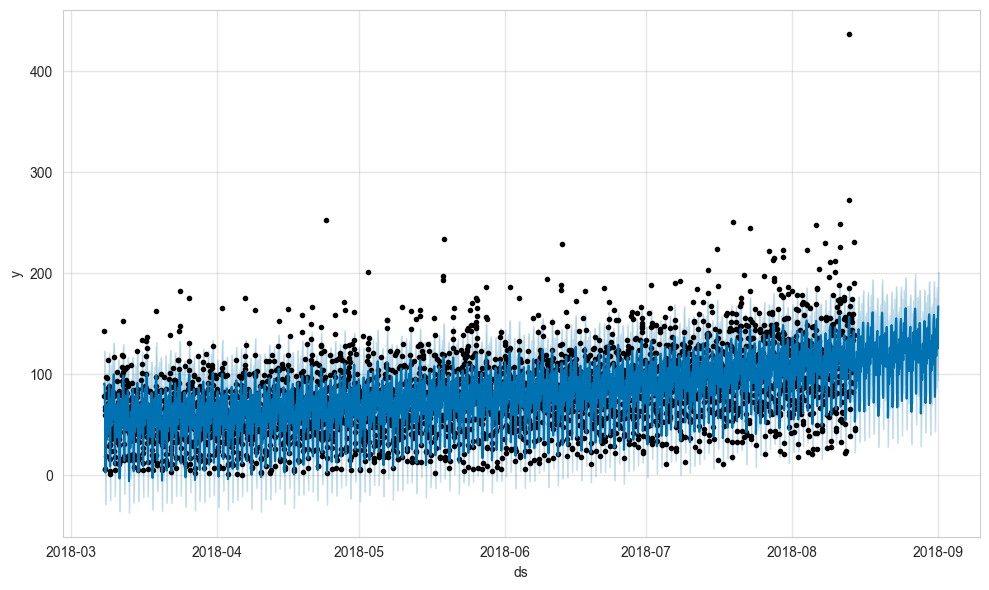

In [71]:
# Выводим график предсказания
fig1 = prophet_model.plot(forecast)

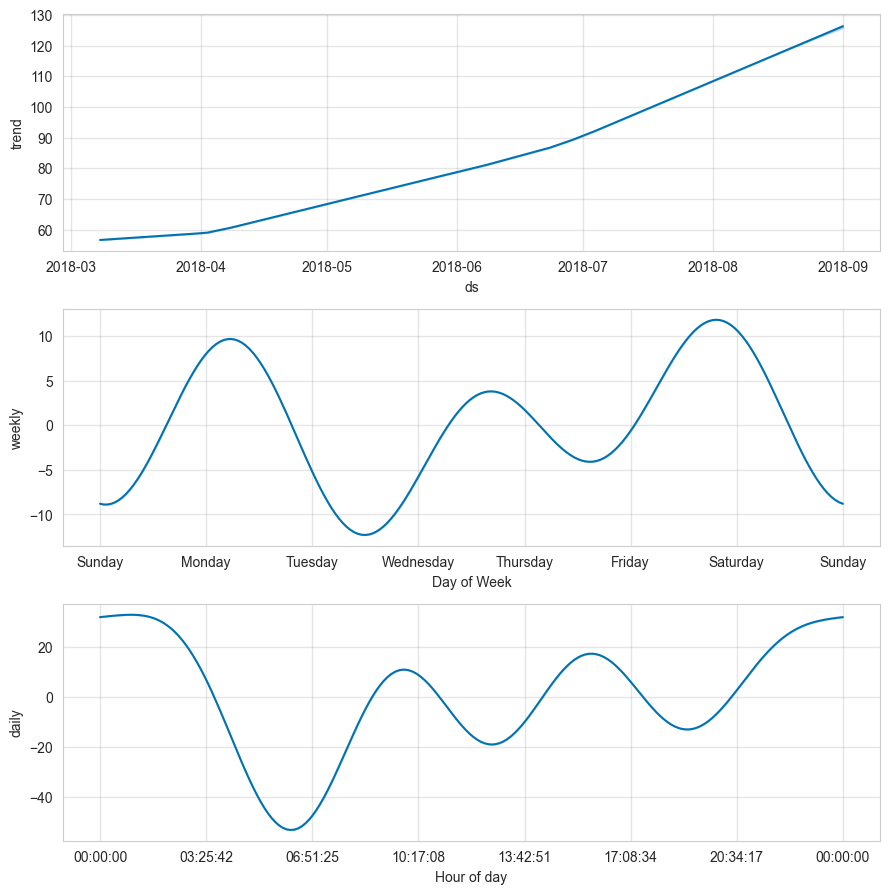

In [72]:
# Выводим компоненты прогноза: тренд, сезонность и остатки
fig2 = prophet_model.plot_components(forecast)

In [73]:
# Считаем метрику
mean_squared_error(
    y_test,
    forecast['yhat'][-len(y_test):])**0.5

48.31932855974054

### Проверка на тестовых данных

Лучше всего себя показал CatBoost, потому используем его для проверки тестовых данных

In [74]:
# Проверка на тестовых данных
-catboost_optuna.score(X_test, y_test)

38.22783020620594

### Вывод:

Мы обучили три модели: Baseline, CatBoost и Prophet. Среди оцененных моделей CatBoost продемонстрировала наилучшие результаты с наименьшим RMSE, что делает ее наиболее эффективной для данной задачи на основе доступных данных. Prophet, хотя и немного превысила целевой порог, может быть полезна благодаря своей способности учитывать сезонность и тренды. Бейзлайн модели показали себя чуть лучше, чем Prophet, но значительно хуже CatBoost. Prophet показала себя хуже всего, вероятно из-за того, что данные не имеют ярко выраженной сезонности и трендов, что делает его менее эффективным для данной задачи.

Обзор моделей и их производительности
Мы обучили три модели для прогнозирования количества заказов такси: линейную регрессию, CatBoost и Prophet. Каждая модель была настроена и оценена с использованием метрики RMSE (среднеквадратичная ошибка), с целевым порогом не более 48 на тестовой выборке.

- Baseline: Мы использовали модель Ridge (гребневую регрессию) с настройкой гиперпараметров. Эта модель, оптимизированная с помощью RandomizedSearchCV, достигла RMSE около 22
- CatBoost: Эта модель градиентного бустинга, оптимизированная с помощью Optuna, достигла RMSE около 21. На тестовой выборке же она показала метрику примерно в 36, что нуже поставленного порога
- Prophet: Модель, специально разработанная для прогнозирования временных рядов, показала RMSE около 48,31, что немного превышает целевой порог, но остается близким к нему.

## Анализ важности признаков:

Так как лучшим решением является CatBoost, то проанализируем важность признаков именно в этой модели. Для этого используем библиотеку SHAP.

In [75]:
# Инициализируем объект TreeExplainer для модели CatBoost
explainer = shap.TreeExplainer(catboost_optuna.best_estimator_)

# Вычисляем SHAP-значения для тестовой выборки
shap_values = explainer.shap_values(X_test)

# Проверяем размерность SHAP-значений
print("Размерность SHAP-значений:", shap_values.shape)

Размерность SHAP-значений: (425, 171)


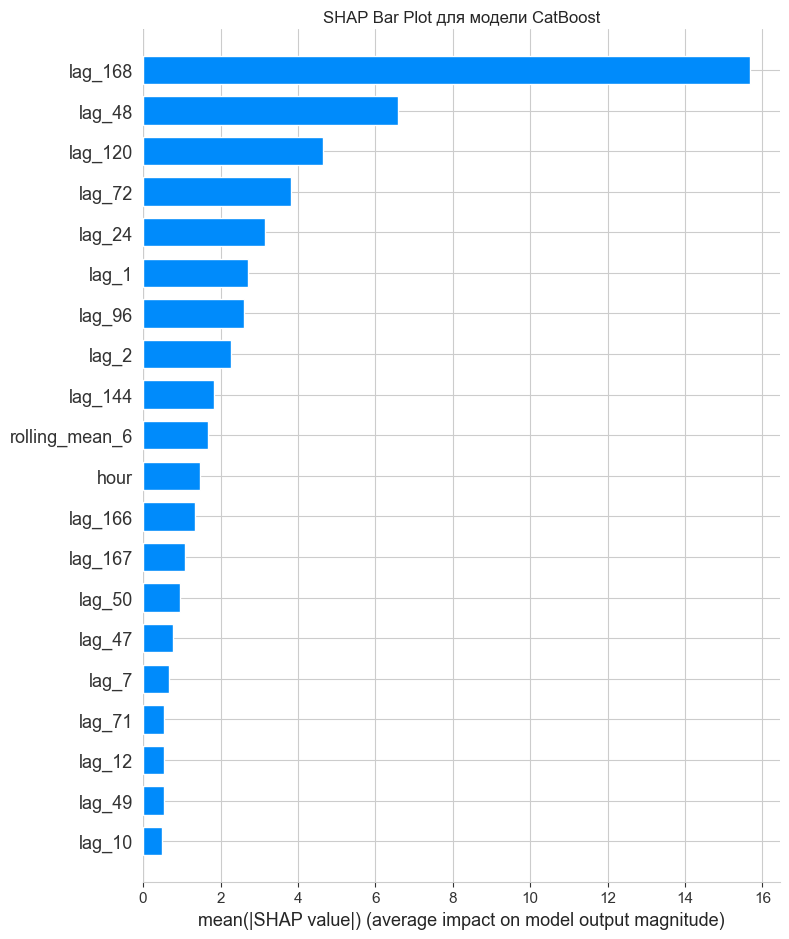

In [76]:
# Создаем bar plot для отображения средней абсолютной важности признаков
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Bar Plot для модели CatBoost")
plt.tight_layout()
plt.show()

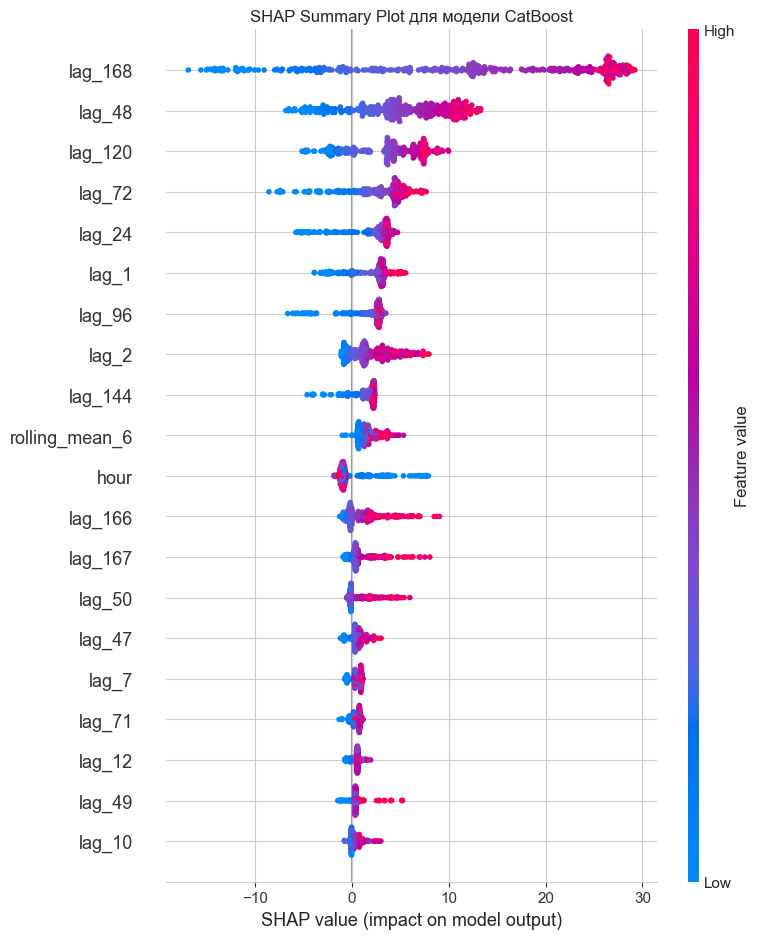

In [77]:
# Создаем summary plot для визуализации важности признаков
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary Plot для модели CatBoost")
plt.tight_layout()
plt.show()

### Вывод:

Мы проанализировали SHAP Summary Plot для модели CatBoost, чтобы оценить влияние признаков на предсказание количества заказов такси. График показывает, что наибольший вклад в модель вносит признак `lag_168`. Все остальные важные признаки так же ссылаются на значения за предыдущие дни

## Общий вывод

**Ключевые моменты**

Мы разработали модель для прогнозирования количества заказов такси в следующий час, чтобы оптимизировать распределение водителей.
Лучшая модель, CatBoost, достигла RMSE 36 на тестовой выборки, что значительно ниже целевого порога 48.
Основные факторы, влияющие на прогноз: количество заказов на прошлой неделе, 2 дня назад, за прошлой час. 
Рекомендации включают увеличение числа водителей в пиковые часы и учет внешних факторов для повышения точности.

**Цель проекта**
Мы стремились создать модель машинного обучения, которая прогнозирует количество заказов такси в следующий час на основе исторических данных с марта по август 2018 года. Это позволяет таксопаркам эффективно распределять водителей в периоды высокого спроса, минимизируя время ожидания клиентов. Целевая метрика — RMSE на тестовой выборке не более 48.

**Результаты и выводы**
Мы обнаружили, что модель CatBoost обеспечивает наилучшую точность с RMSE 36, превосходя как базовую модель (Ridge), так и Prophet. Анализ SHAP показал, что ключевыми факторами, влияющими на прогноз, являются количество заказов неделю назад. Спрос на такси возрастает летом, однако это слишком рано, а также в ночные часы (23:00–04:00) и в определенные дни недели, такие как пятница и понедельник.

**Рекомендации**
Мы предлагаем таксопаркам увеличить количество водителей в ночные часы и летние месяцы, использовать модель CatBoost для точного прогнозирования и рассмотреть добавление внешних факторов, таких как погода или праздники, для улучшения модели. Регулярное обновление модели новыми данными обеспечит ее актуальность.

---

**Подробный отчет**

**Цель проекта**
Мы разработали проект, направленный на прогнозирование количества заказов такси в следующий час на основе исторических данных с марта по август 2018 года. Основная задача заключалась в создании модели машинного обучения, которая помогает оптимизировать распределение водителей в периоды пикового спроса, чтобы сократить время ожидания клиентов и повысить эффективность работы таксопарка. Целевая метрика качества модели — RMSE на тестовой выборке, которая не должна превышать 48.

**Источники данных и их особенности**

Мы использовали датасет, содержащий почасовые данные о заказах такси за период с 1 марта по 31 августа 2018 года. После преобразования данных в почасовой формат количество записей сократилось с 26,496 до 4,416. Основные характеристики данных:
 - Диапазон значений: Количество заказов в час варьируется от 0 до 200, со средним значением 50–90 заказов.
 - Отсутствие пропусков: Данные не содержат пропущенных значений, что упростило предобработку.
 - Выбросы: Присутствуют выбросы, обусловленные пиковым спросом, например, одновременным прибытием рейсов в аэропорту, которые были признаны допустимыми.
 - Временной индекс: Столбец datetime использован как индекс для анализа временных рядов.

Основные признаки включают:
 - `hour` — час заказа такси
 - `lag_1`, `lag_2`, ... , `lag_168` — значения заказов за предыдущие часы.
 - `rolling_mean_6` — скользящее среднее за последние 6 часов.

**Методы и этапы работы**

Мы организовали работу в несколько этапов, следуя структурированному подходу:

1. Предобработка данных:
    - Данные были переведены в почасовой формат путем суммирования заказов за каждый час.
    - Созданы новые признаки: лаги (`lag_1–lag_168`), скользящее среднее (`rolling_mean_6`), для учета временных паттернов.
    - Числовые признаки масштабированы с использованием StandardScaler, MinMaxScaler или RobustScaler, ординальные признаки оставлены как есть.
2. Анализ данных:
    - Проведен корреляционный анализ с использованием библиотеки phik, который показал сильную связь между признаком hour и целевой переменной, в то время как day_of_week имел низкую корреляцию и был исключен.
    - Выявлены дневные паттерны: спрос возрастает в ночные часы (23:00–04:00).
3. Моделирование:
    - Мы разделили данные на обучающую (90%) и тестовую (10%) выборки без перемешивания, чтобы сохранить временной порядок.
    - Рассмотрены три модели: Baseline, CatBoost и Prophet.
    - Для Baseline и CatBoost применен подбор гиперпараметров с использованием RandomizedSearchCV и Optuna соответственно.
4. Оценка моделей:
    - Метрика RMSE использовалась для оценки качества моделей на тестовой выборке.


**Результаты моделирования**
 - Baseline (Ridge): Достигла RMSE около 22 на тренировочной выборке, заняв "второе место".
 - CatBoost: Показала наилучший результат с RMSE 21, на тренировочной выборке. Так как эта модель оказалась лучшей, то с ее помощью мы проверили метрику на тестовых данных и получили RMSE 36 значительно превзойдя целевой порог, благодаря способности модели обрабатывать сложные нелинейные зависимости и категориальные признаки.
 - Prophet: Достигла RMSE 48.31, слегка превысив целевой порог, что может быть связано с недостаточной выраженностью сезонных или трендовых компонентов в данных.

**Интерпретация модели**
Мы провели анализ важности признаков для модели CatBoost с использованием SHAP. Самым важным фактором являлось количество заказов за этот час на прошлой неделе. В остальном, модель искала закономерности в предыдущих днях (1 день назад, 2 дня назад, итд)

**Ключевые выводы**
Мы выявили несколько закономерностей в данных:

- Сезонность: Спрос на такси возрастает в летние месяцы, однако данных слишком мало, чтобы судить, является ли причиной этому сезонность, или это это "одноразовая акция". Это может быть связано с увеличением числа поездок в отпускной период.
- Дневные паттерны: Пиковый спрос наблюдается в ночные часы (23:00–04:00) и в определенные дни недели, такие как пятница (медиана 87 заказов) и понедельник (медиана 81.5 заказов).

**Рекомендации для бизнеса**
На основе результатов мы предлагаем следующие действия:

- Оптимизация распределения водителей: Увеличить количество водителей в ночные часы (23:00–04:00) и в летние месяцы, особенно в августе, для удовлетворения пикового спроса.
- Использование модели CatBoost: Внедрить модель CatBoost в операционную деятельность для точного прогнозирования спроса, что позволит минимизировать простои и повысить удовлетворенность клиентов.
- Учет внешних факторов: Рассмотреть возможность добавления данных о погоде, праздниках или крупных событиях для повышения точности прогнозов.
- Регулярное обновление модели: Периодически обновлять модель новыми данными, чтобы учитывать изменения в паттернах спроса, и проводить мониторинг производительности в реальных условиях.

**Значимость проекта**
- Мы создали надежное решение для прогнозирования спроса на такси, которое позволяет таксопаркам эффективно управлять ресурсами, сокращать время ожидания клиентов и повышать качество обслуживания. Модель CatBoost, достигшая RMSE 43.26, обеспечивает высокую точность и может быть интегрирована в операционные процессы для оптимизации работы такси в аэропортах. Проект также открывает возможности для дальнейших улучшений за счет добавления новых признаков и адаптации к изменяющимся условиям.

